In [1]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
import os
import warnings
import os, sys
import numpy as np
import keras
import cv2
from skimage import io,transform
from tflearn.layers.conv import global_avg_pool
from keras.models import Model
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.models import Model
from keras import layers
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.callbacks import Callback
from keras.applications.vgg16 import VGG16, preprocess_input
import matplotlib.pyplot as plt


C:\Users\s110024\AppData\Local\conda\conda\envs\ML2018\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
def loading(dirs = os.getcwd()):

    trainMatrix = []
    trainLabel = []
    testMatrix = []
    testLabel = []
    countOfPeople = 0
    for i in range(1, 40):
        if i == 14:
            continue
        file = os.path.join(dirs, 'CroppedYale', 'yaleB%02d' % i, '*.pgm')
    
        rawImg = io.imread_collection(file)
        imgs = np.array([cv2.resize(img, (224,224), interpolation = cv2.INTER_CUBIC) for img in rawImg])
        imgs = np.array(imgs, dtype=np.int64)
        
        rimgs = np.random.permutation(imgs)
        rimgs = np.array(rimgs)
        
        countOfPeople = len(rimgs)
        
        train = rimgs[0:35]
        trainMatrix.append(train)
        for j in range(0, 35): trainLabel.append(i)
            
        test = rimgs[countOfPeople-30:countOfPeople]
        testMatrix.append(test)
        for j in range(0, 30): testLabel.append(i) 

        
    return trainMatrix, trainLabel, testMatrix, testLabel

In [3]:
trainMatrix, trainLabel, testMatrix, testLabel = loading(os.getcwd())


trainCount = np.size(trainLabel, 0)
testCount = np.size(testLabel, 0)

trainMatrix = np.array(trainMatrix).reshape(trainCount,224,224,1)

# change one channel to three
original = trainMatrix
trainMatrix = np.resize(trainMatrix,(trainCount,224,224,3))
trainMatrix[:,:,:,0:1] = original
trainMatrix[:,:,:,1:3] = 0     #channel two and three = 0


testMatrix = np.array(testMatrix).reshape(testCount,224,224,1)

# change one channel to three
original = testMatrix
testMatrix = np.resize(testMatrix,(testCount,224,224,3))
testMatrix[:,:,:,0:1] = original
testMatrix[:,:,:,1:3] = 0



print("TrainCount: %d" % trainCount)
print("TestCount: %d" % testCount)

TrainCount: 1330
TestCount: 1140


In [4]:
trainLabel_encode = np_utils.to_categorical(trainLabel, num_classes=40)
testLabel_encode = np_utils.to_categorical(testLabel, num_classes=40)

In [5]:
vgg = VGG16(weights='model.h5', include_top=False, input_shape=(224, 224, 3))
x = vgg.output
x = Conv2D(1024, (3, 3), activation='relu', padding='same', name='block6_conv1')(x)
x = Conv2D(1024, (3, 3), activation='relu', padding='same', name='block6_conv2')(x)
x = Conv2D(1024, (3, 3), activation='relu', padding='same', name='block6_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block6_pool')(x)

x = Flatten()(x)
x = Dense(40, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=x)
model.summary()
sgd = SGD(lr=0.0001, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(trainMatrix, trainLabel_encode, epochs=50, batch_size=32, 
                    validation_data=(testMatrix, testLabel_encode), verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Epoch 34/50
1330/1330 [==============================] - 54s 41ms/step - loss: 0.0458 - acc: 0.9917 - val_loss: 1.5805 - val_acc: 0.6684
Epoch 35/50
1330/1330 [==============================] - 55s 41ms/step - loss: 0.0451 - acc: 0.9917 - val_loss: 1.5855 - val_acc: 0.6632
Epoch 36/50
1330/1330 [==============================] - 54s 41ms/step - loss: 0.0444 - acc: 0.9917 - val_loss: 1.5869 - val_acc: 0.6658
Epoch 37/50
1330/1330 [==============================] - 54s 41ms/step - loss: 0.0438 - acc: 0.9917 - val_loss: 1.5880 - val_acc: 0.6667
Epoch 38/50
1330/1330 [==============================] - 54s 41ms/step - loss: 0.0432 - acc: 0.9925 - val_loss: 1.5989 - val_acc: 0.6623
Epoch 39/50
1330/1330 [==============================] - 54s 41ms/step - loss: 0.0426 - acc: 0.9932 - val_loss: 1.5985 - val_acc: 0.6640
Epoch 40/50
1330/1330 [==============================] - 54s 41ms/step - loss: 0.0420 - acc: 0.9932 - val_loss: 1.5991 - val_acc: 0.6649
Epoch 41/50
1330/1330 [==================

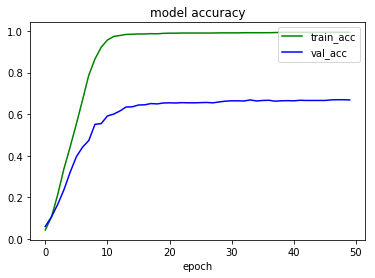

In [6]:
plt.plot(history.history['acc'], 'g', label='train_acc')
plt.plot(history.history['val_acc'], 'b', label='val_acc')
plt.legend(loc='upper right')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.show()

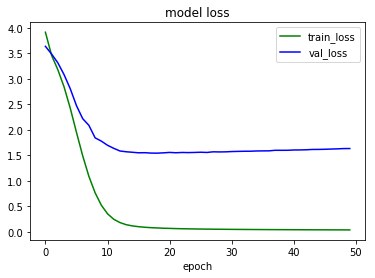

In [7]:
plt.plot(history.history['loss'], 'g', label='train_loss')
plt.plot(history.history['val_loss'], 'b', label='val_loss')
plt.legend(loc='upper right')
plt.title('model loss')
plt.xlabel('epoch')
plt.show()

In [8]:
loss, acc = model.evaluate(x = testMatrix, y = testLabel_encode, batch_size = 32)
print("loss : ", loss)
print("accuracy : ", acc)

1140/1140 [==============================] - 12s 11ms/step
loss :  1.6330566192928113
accuracy :  0.6684210530498571
